# How to handle tool errors

Calling tools with an LLM is generally more reliable than pure prompting, but it isn't perfect. The model may try to call a tool that doesn't exist or fail to return arguments that match the requested schema. Strategies like keeping schemas simple, reducing the number of tools you pass at once, and having good names and descriptions can help mitigate this risk, but aren't foolproof.

This guide covers some ways to build error handling into your graphs to mitigate these failure modes.

## Using the prebuilt `ToolNode`

To start, define a mock weather tool that has some hidden restrictions on input queries. The intent here is to simulate a real-world case where a model fails to call a tool correctly:

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_anthropic

In [5]:
from langchain_core.tools import tool

@tool
def get_weather(location: str):
    """Call to get the current weather."""
    if "san francisco" in location.lower():
        raise ValueError("Only abbreviations are accepted for input queries")
    elif "sf" in location.lower():
        return ["It's 60 degrees and foggy."]
    else:
        raise ValueError('Invalid input.')

Next, set up a graph implementation of the [ReAct agent](https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/#react-agent). This agent takes some query as input, then repeatedly call tools until it has enough information to resolve the query. We'll use the prebuilt [`ToolNode`](https://langchain-ai.github.io/langgraph/reference/prebuilt/#toolnode) to execute called tools, and a small, fast model powered by Anthropic:

In [6]:
from typing import Literal

from langchain_anthropic import ChatAnthropic
from langgraph.graph import StateGraph, MessagesState
from langgraph.prebuilt import ToolNode

tool_node = ToolNode([get_weather])

model = ChatAnthropic(model="claude-3-haiku-20240307", temperature=0).bind_tools([get_weather])

def should_continue(state: MessagesState) -> Literal["tools", "__end__"]:
    messages = state['messages']
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return "__end__"


def call_model(state: MessagesState):
    messages = state['messages']
    response = model.invoke(messages)
    return {"messages": [response]}


workflow = StateGraph(MessagesState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge("__start__", "agent")
workflow.add_conditional_edges(
    "agent",
    should_continue,
)
workflow.add_edge("tools", 'agent')

app = workflow.compile()

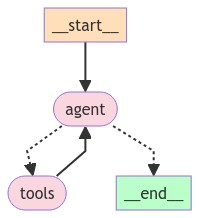

In [3]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

When you try to call the tool, you can see that the model calls the tool with a bad input, causing the tool to throw an error. The prebuilt `ToolNode` that executes the tool has some built-in error handling that captures the error and passes it back to the model so that it can try again:

In [7]:
app.invoke(
    {"messages": [("human", "what is the weather in san francisco?")]},
)

{'messages': [HumanMessage(content='what is the weather in sf', id='e9d63736-c388-48bc-8ef5-315d4aa26534'),
  AIMessage(content=[{'text': 'Okay, let me check the weather for San Francisco (SF).', 'type': 'text'}, {'id': 'toolu_018BW6anqMNVgWjXyhW8o1PG', 'input': {'location': 'San Francisco'}, 'name': 'get_weather', 'type': 'tool_use'}], response_metadata={'id': 'msg_01U96cLhgwNUEBaeF8jTKRWm', 'model': 'claude-3-sonnet-20240229', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'input_tokens': 226, 'output_tokens': 68}}, id='run-698da99d-fc6c-4ac5-90d8-d99579916952-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'San Francisco'}, 'id': 'toolu_018BW6anqMNVgWjXyhW8o1PG'}], usage_metadata={'input_tokens': 226, 'output_tokens': 68, 'total_tokens': 294}),
  ToolMessage(content="Error: ValueError('Only abbreviations are accepted for input queries')\n Please fix your mistakes.", name='get_weather', id='dedf13b9-d268-4357-9193-47ef44d1f6ab', tool_call_id='toolu_018BW6anq

## Custom strategies

This is a fine default in many cases, but there are cases where custom fallbacks may be better.

For example, the below tool requires as input a list of elements of a specific length - tricky for a small model! We'll also intentionally avoid pluralizing `topic` to trick the model into thinking it should pass a string:

In [25]:
from pydantic import BaseModel, conlist

model = ChatAnthropic(model="claude-3-haiku-20240307", temperature=0)

class HaikuRequest(BaseModel):
    topic: conlist(str, min_items=3, max_items=3)

@tool
def master_haiku_generator(request: HaikuRequest):
    """Generates a haiku based on the provided topics."""
    topics = ", ".join(request.topic)
    haiku = model.invoke(f"Write a haiku about {topics}")
    return haiku

tool_node = ToolNode([master_haiku_generator])

model_with_tools = model.bind_tools([master_haiku_generator])

def should_continue(state: MessagesState) -> Literal["tools", "__end__"]:
    messages = state['messages']
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return "__end__"


def call_model(state: MessagesState):
    messages = state['messages']
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}


workflow = StateGraph(MessagesState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge("__start__", "agent")
workflow.add_conditional_edges(
    "agent",
    should_continue,
)
workflow.add_edge("tools", 'agent')

app = workflow.compile()

app.invoke(
    {"messages": [("human", "Write me an incredible haiku about water.")]},
    {"recursion_limit": 10}
)

{'messages': [HumanMessage(content='Write me an incredible haiku about water.', id='0d5d5337-f018-4c2f-ac45-7660ac0d1929'),
  AIMessage(content=[{'text': 'Here is a haiku about water:', 'type': 'text'}, {'id': 'toolu_01Xqz9EcC81qDHapA25m8JEA', 'input': {'topic': ['water']}, 'name': 'master_haiku_generator', 'type': 'tool_use'}], response_metadata={'id': 'msg_01Q2pSp9Zd4twvKiSzLFUu7c', 'model': 'claude-3-haiku-20240307', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'input_tokens': 384, 'output_tokens': 67}}, id='run-fca377ca-afbb-44d2-a8e0-137944343df8-0', tool_calls=[{'name': 'master_haiku_generator', 'args': {'topic': ['water']}, 'id': 'toolu_01Xqz9EcC81qDHapA25m8JEA'}], usage_metadata={'input_tokens': 384, 'output_tokens': 67, 'total_tokens': 451}),
  ToolMessage(content="Error: ValidationError(model='master_haiku_generatorSchema', errors=[{'loc': ('request',), 'msg': 'field required', 'type': 'value_error.missing'}])\n Please fix your mistakes.", name='master_haiku_ge

We can see that the model takes multiple tries to get the input correct. Additionally, it doesn't actually return the generated haiku in the final answer because it gets so distracted by all the retries!

A better strategy might be to fall back to a more advanced model. Here's an example that uses a custom node instead of the prebuilt `ToolNode`:

In [ ]:
from pydantic import BaseModel, conlist

model = ChatAnthropic(model="claude-3-haiku-20240307", temperature=0)

class HaikuRequest(BaseModel):
    topic: conlist(str, min_items=3, max_items=3)

@tool
def master_haiku_generator(request: HaikuRequest):
    """Generates a haiku based on the provided topics."""
    topics = ", ".join(request.topic)
    haiku = model.invoke(f"Write a haiku about {topics}")
    return haiku

def call_tool(state: MessagesState):
    
    pass

model_with_tools = model.bind_tools([master_haiku_generator])

def should_continue(state: MessagesState) -> Literal["tools", "__end__"]:
    messages = state['messages']
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return "__end__"


def call_model(state: MessagesState):
    messages = state['messages']
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}


workflow = StateGraph(MessagesState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge("__start__", "agent")
workflow.add_conditional_edges(
    "agent",
    should_continue,
)
workflow.add_edge("tools", 'agent')

app = workflow.compile()

app.invoke(
    {"messages": [("human", "Write me an incredible haiku about water.")]},
    {"recursion_limit": 10}
)